# Quaternions (and rotations!)

Having learned about complex numbers and their properties, it's really time to kick it up a notch: Quaternions are like an extended complex number, in that they have not one but three hyper-imaginary components. Quaternions are an industry standard way to perform rotations in 3D graphics, but they operate very differently to matrix transformations.

In this notebook we will explore some of the properties of quaternions, and then apply those properties to rotate objects in 3D space.

In [1]:
## Libraries
%matplotlib inline
import numpy as np
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import sympy as sym

## Introduction
Quaternions are like an extended form of complex number. They have one real and *three* hyperimaginary components, for example:

$$
\vec{q} = a+b\vec{i}+c\vec{j}+d\vec{k}.
$$

In this course we will label each of the $i,j,k$ components as vectors, as we will be learning to exploit their properties to perform rotations in 3D space.

Quaternions have various properties that make them fantastic at performing rotations, as discussed in lectures.

To play with quaternions in Python, we have to use a custom Python package that isn't commonly installed on Colab, so we need to force it to remember and reinstall if necessary:

In [2]:
import sys
!{sys.executable} -m pip install --upgrade numpy-quaternion
import quaternion

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip


Now we can store and play with quaternions:

In [3]:
q1 = np.quaternion(1,2,3,4)
q2 = np.quaternion(5,6,7,8)

Python isn't strictly built to mess with quaternions, so to illustrate some of rotations later, we'll first set up some functions to carry out certain operations that we will use later. These functions are based on the concepts taught in lectures. For example, it will be useful to quickly evaluate the modulus and inverse of a given quaternion:

In [4]:
def modq(q):
  """Function to create the |q| of a given quaternion.
  """
  import quaternion
  mq = q.w*q.w+q.x*q.x+q.y*q.y+q.z*q.z
  mq = np.sqrt(mq)
  return mq

def invertq(q):
  """Function to create q^(-1) of a given quaternion.
  """
  import quaternion
  mq = q.w * q.w + q.x * q.x + q.y * q.y + q.z * q.z
  mq = np.sqrt(mq)
  q_inverse = q.conjugate()/mq
  return q_inverse

The quaternion numpy addon package is capable of calculating the conjugate of a given quaternion, so lets now check that this and our functions calculate exactly what we would expect:

In [5]:
print(np.sqrt(q1.w * q1.w + q1.x * q1.x + q1.y * q1.y + q1.z * q1.z))
print(modq(q1))
q1.conjugate()
print(invertq(q1))

5.477225575051661
5.477225575051661
quaternion(0.182574185835055, -0.365148371670111, -0.547722557505166, -0.730296743340221)


We want to use quaternions to rotate objects. Our lectures described a specific method to rotate a chosen point about a specific axis. One must express the point as a quaternion $p$, before formatting the rotation as a quaternion $q_r$. Once done, the rotation can be carried out using the operations $q_r p q_r^{-1}$. 

To help us implement these quickly in Python, let us again define some specific functions to convert a point to a quaternion, or a quaternion into a point. We can also create functions which, if given a rotation angle and axis, generate the equivalent quaternion, and one which will evaluate a rotation angle and axis from a given quaternion.


In [6]:
def point2quat(p):
  """Function to convert a point to a quaternion
  """
  import quaternion
  q = np.quaternion(0, p[0], p[1], p[2])
  return q

def quat2point(q):
  """Function to convert a point to a quaternion
  """
  import quaternion
  p = [q.x, q.y, q.z]
  return p

def rotation2quat(theta, v):
  """Function to represent an axis and rotation angle using quaternions
  with theta read in degrees
  """
  import quaternion
  rtheta = 0.5 * theta
  modv = np.sqrt(v[0]*v[0] + v[1]*v[1] + v[2]*v[2])
  myI = v / modv
  ct = np.cos(np.radians(rtheta))
  st = np.sin(np.radians(rtheta))
  q = np.quaternion(ct,myI[0]*st,myI[1]*st,myI[2]*st)
  return q

def quat2rotation(q):
  """Function to break apart quaternion to display rotation axis and angle
  """
  import quaternion
  mq = q.w * q.w + q.x * q.x + q.y * q.y + q.z * q.z
  mq = np.sqrt(mq) 
  theta = math.degrees(np.arccos(q.w / mq))
  axis = [q.x, q.y, q.z]
  print("theta=",2.*theta, " axis=",axis)  

Let us now put these processes to the test. In our lectures we encountered several examples. 

### Example 1: rotation using quaternions
The point $(2,3,1)$ is to be rotated about the $x$-axis by $90^o$ using quaternions.
 
In only a few lines we can use Python to carry out the same rotation: 

In [7]:
pt = [2,3,1]
qp = point2quat(pt) #convert point to quaternion form
print(qp)
theta = 90
axis = [1,0,0]
qr = rotation2quat(theta,axis) #rotate point about specified axis
print(qr)
qri = invertq(qr) #calculate inverse of quaternion
print(qri)

quaternion(0, 2, 3, 1)
quaternion(0.707106781186548, 0.707106781186547, 0, 0)
quaternion(0.707106781186548, -0.707106781186547, -0, -0)


In [8]:
im = quat2point(qr * qp * qri) #q * p * q^(-1)
print(im)

[2.0, -0.9999999999999993, 3.0]


The image location displayed above matches the location we determined in the lectures using our mathematics.

What about if we could somehow visualise this rotation further?
To display an axis, we could create a type of arrow to indicate size and direction of any vectors:

In [9]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

Now lets display the arrow (representing the axis of rotation), the original point and the rotated image of that point. We can add in a curved arrow indicating the direction of rotation and some text to help identify which object is which:

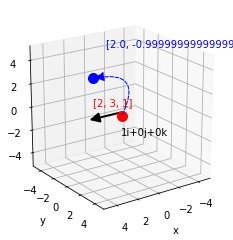

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 55)
ax.scatter(pt[0], pt[1], pt[2], color="r", s=100)
ax.text(pt[0]+2, pt[2]+1, pt[2]+1, pt, c='r')
ax.scatter(im[0], im[1], im[2], color="b", s=100)
ax.text(im[0]-2, im[1]-1, im[2]+2, im, c='b')
ax.axes.set_xlim3d(left=-5, right=5) 
ax.axes.set_ylim3d(bottom=-5, top=5) 
ax.axes.set_zlim3d(bottom=-5, top=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
vstring="{}i+{}j+{}k".format(axis[0],axis[1],axis[2])
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([0, 3*axis[0]], [0, 3*axis[1]], [0, 3*axis[2]], **arrow_prop_dict)
ax.text(0, 0, -2, vstring, c='k')
a2 = Arrow3D([pt[0], im[0]], [pt[1], im[1]], [pt[2], im[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="b", connectionstyle="arc3,rad=1", linestyle='--')

ax.add_artist(a)
ax.add_artist(a2)
ax.set_box_aspect([1,1,1])
plt.show()

Example 2 in the lectures can also be evaluated this way, and displayed using the same tools:

## Example 2
The point $(1,0,-2)$ is to be rotated by $60^o$ about the axis $\vec{i}+2\vec{j}-\vec{k}$. Carry out the rotation using quaternions.


In [11]:
pt2 = [1, 0, -2]
qp2 = point2quat(pt2)
axis2 = [1,2,-1]
theta2 = 60.0
qr2 = rotation2quat(theta2,axis2)
qri2 = invertq(qr2)
im2 = quat2point(qr2 * qp2 * qri2)
print(im2)

[-0.664213562373095, 0.8535533905932737, -1.9571067811865477]


We can also visualise this rotation in 3D, using arrows to illustrate the rotation axis, the rotation itself and the old and new image locations:

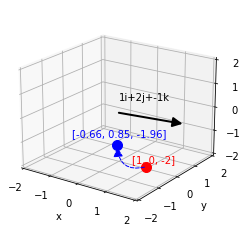

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -55)
imtext=[round(float(i), 2) for i in im2]
ax.scatter(pt2[0], pt2[1], pt2[2], color="r", s=100)
ax.text(pt2[0]+0.5, pt2[2]+0.5, pt2[2]+1, pt2, c='r')
ax.scatter(im2[0], im2[1], im2[2], color="b", s=100)
ax.text(im2[0]-1, im2[1]-1, im2[2]+0.5, imtext, c='b')
ax.axes.set_xlim3d(left=-2, right=2) 
ax.axes.set_ylim3d(bottom=-2, top=2) 
ax.axes.set_zlim3d(bottom=-2, top=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
vstring="{}i+{}j+{}k".format(axis2[0],axis2[1],axis2[2])
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([0,axis2[0]], [0, axis2[1]], [0, axis2[2]], **arrow_prop_dict)
ax.text(0, 0, 0.5, vstring, c='k')
a2 = Arrow3D([pt2[0], im2[0]], [pt2[1], im2[1]], [pt2[2], im2[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="b", connectionstyle="arc3,rad=-0.6", linestyle='--')

ax.add_artist(a)
ax.add_artist(a2)
plt.show()

## Example 3
Example 3 used the same direction for the axis of rotation as in Example 1, but now passing through a specific point. To carry out this example, we must first translate the point before carrying out the rotation, then translating the point back by the same amount at the end:



In [13]:
ptT = [a - b for a, b in zip(pt, [-1,2,1])]
qp3 = point2quat(ptT)
imT = quat2point(qr * qp3 * qri)
im3 = [a + b for a, b in zip(imT, [-1,2,1])]
print(im3)
print(imT)

[2.0, 2.0, 2.0]
[3.0, 2.220446049250313e-16, 1.0]


##Concatenation

One of the most powerful aspects of quaternion rotations involves concatenation: the idea that multiple rotations in sequence can be represented by a single equivalent quaternion.

To follow a rotation $q_1pq_1^{-1}$ by a second rotation $q_2$, we would form $q_2(q_1pq_1^{-1})q_2^{-1}$. All the information about both rotations is stored in a quaternion $q_2q_1$ (and it's inverse, $(q_2q_1)^{-1}$, since $q_1^{-1}q_2^{-1}=(q_2q_1)^{-1}$). By multiplying the two quaternions together to form one new quaternion, we have stored all the information about two rotations in one *concatenated* quaternion.

###Example 1
In the lectures, this was illsutated by an example. The point $(-1,0,1)$ was to be rotated about the $z$-axis by $120^o$, followed by a rotation of $-90^o$ about an axis parallel to $\underset{\bar{}}{i}-\underset{\bar{}}{k}$.

To carry this out using Python, we can create the two required quaternions, multiply them, find the inverse of the result, then perform the rotation. 

In [14]:
qrc1 = rotation2quat(120, [0, 0, 1])
qrc2 = rotation2quat(-90, [1, 0, -1])
q2q1 = qrc2 * qrc1
q2q1_inverse = invertq(q2q1)
pc1 = [-1,0,1]
qpc = point2quat(pc1)
print(q2q1 * qpc * q2q1_inverse)
imc = quat2point(q2q1 * qpc * q2q1_inverse)


quaternion(0, 0.362372435695795, 1.06066017177982, 0.862372435695795)


To convert the quaternion back to a rotation, we can use the *quat2rotation* function we created earlier:

In [15]:
quat2rotation(q2q1)

theta= 189.11497523669803  axis= [-0.25, 0.4330127018922192, 0.8623724356957946]


As expected, the solutions determined by Python match those we found using mathematics in the lectures.


##Over to you
Now it's over to you. Examine some of the examples you completed in the tutorial questions, and see if Python is able to confirm your tactics and solutions. What do the old and new locations look like in 3D after you have performed the rotation?